In [1]:

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
import numpy as np

from matplotlib import pyplot as plt
from crawlab_toolbox import plotting as genplt
from sklearn.pipeline import Pipeline

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support

from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import OneClassSVM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


import matplotlib.colors as colors
import kerastuner as kt

from scipy import signal

from scipy.stats import probplot
from scipy.stats import normaltest


from joblib import dump, load

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Variational_AE import create_autoencoder as create_conv_vae
from ML_Train.Convolutional_AE import create_autoencoder as create_conv_ae
from ML_Train.Variational_Vanilla_AE import create_autoencoder as create_vanilla_vae
from ML_Train.CNN_Classifier import create_autoencoder as create_hybrid_cnn_ae
from ML_Train.CNN_Classifier import  build_classifier_from_vae, create_vae, create_classifier
# mse = keras.metrics.mean_squared_error(all_outputs,input_data)

Using TensorFlow backend.


In [2]:
keras.backend.clear_session()
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


In [3]:
def fft_from_vib(values):
    _,amps = signal.welch(values, fs=20e3, nperseg=4096, scaling='spectrum')
    amps /= 0.01
#     lin_amps = lin_log_interp(amps)
    return amps


def lin_log_interp(fft_features):
    '''
    Scale the fft features from the logarithmic axis to be approximately on 
    the interval from 0 to 1
    '''
    
    # Minimum exponent we expect to see in the data
    minimum = -12
    
    # Maximum exponent we expect to see
    maximum = 0
    
    # Number of points to use for interpolation
    numpoints = 1000
    
    # Map the logarithmic x-axis to a linear y-axis
    x = np.logspace(minimum,maximum,numpoints)
    y = np.linspace(0,1,numpoints)

    # Return the interpolated valuess
    return np.interp(np.log10(fft_features),np.log10(x),y)

In [4]:

DoE_test = np.loadtxt('Experiment-3-Data/DoE_test_pruned.txt',delimiter=',')
DoE_train = np.loadtxt('Experiment-3-Data/DoE_train_pruned.txt',delimiter=',')

In [5]:
max_fft = 128
DoE_shape = 3

trainDF = pd.read_csv('Experiment-3-Data/Vib_train_pruned.csv')
testDF = pd.read_csv('Experiment-3-Data/Vib_test_pruned.csv')

X_train = trainDF.loc[:, trainDF.columns != 'dateTime'].values.astype(np.float32)
X_test = testDF.loc[:, testDF.columns != 'dateTime'].values.astype(np.float32)
Y_train = np.loadtxt('Experiment-3-Data/Y_train_pruned.txt',delimiter=',')
Y_test = np.loadtxt('Experiment-3-Data/Y_test_pruned.txt',delimiter=',')

print(X_test.shape)

first_good_train = np.argwhere(Y_train[:,0] == 0).flatten()[0]
first_good_test = np.argwhere(Y_test[:,0] == 0).flatten()[0]

X_train_original = fft_from_vib(X_train[:,:-1])[:,1:max_fft+1]
X_test_original = fft_from_vib(X_test[:,:-1])[:,1:max_fft+1]

X_train_original = np.hstack((X_train_original,DoE_train))
X_test_original = np.hstack((X_test_original,DoE_test))


X_train_healthy = X_train_original[first_good_train:,:]
X_valid_healthy = X_test_original[first_good_test:,:]
X_train_unhealthy = X_train_original[:first_good_train,:]
X_valid_unhealthy = X_test_original[:first_good_test,:]


Y_train_healthy = np.tile(np.array([[1]]),(X_train_healthy.shape[0],1))
Y_valid_healthy = np.tile(np.array([[1]]),(X_valid_healthy.shape[0],1))
Y_train_unhealthy = np.tile(np.array([[0]]),(X_train_unhealthy.shape[0],1))
Y_valid_unhealthy = np.tile(np.array([[0]]),(X_valid_unhealthy.shape[0],1))

XY_train_healthy = np.hstack((X_train_healthy,Y_train_healthy))
XY_valid_healthy = np.hstack((X_valid_healthy,Y_valid_healthy))
XY_train_unhealthy = np.hstack((X_train_unhealthy,Y_train_unhealthy))
XY_valid_unhealthy = np.hstack((X_valid_unhealthy,Y_valid_unhealthy))

XY_train = np.vstack((XY_train_healthy,XY_train_unhealthy))
XY_valid = np.vstack((XY_valid_healthy,XY_valid_unhealthy))

np.random.shuffle(XY_train)
np.random.shuffle(XY_valid)

X_train = XY_train[:,:max_fft + DoE_shape]
Y_train = XY_train[:,-1]

X_valid = XY_valid[:,:max_fft + DoE_shape]
Y_valid = XY_valid[:,-1]



columns = ['Healthy Train','Healthy Valid','Unhealthy Train','Unhealthy Valid']


(151, 4200)


In [6]:
def plot_confusion_matrix(y_true,y_pred,
                          labels,
                          filename='confusion_matrix'):
    
    predict_label = labels
    true_label = labels.copy()
    
    
    predict_label.insert(0, '')

    conf_matrix = np.round(confusion_matrix(y_true, y_pred) / y_pred.shape[0],2)
    
    true_positive = conf_matrix[0,0]
    true_negative = conf_matrix[1,1]
    false_positive = conf_matrix[0,1]
    false_negative = conf_matrix[1,0]
    
    true_positive_rate = true_positive / (true_positive + false_negative)
    true_negative_rate = true_negative / (true_negative + false_positive)
    
    balanced_accuracy = (true_positive_rate + true_negative_rate) / 2

    fig = plt.figure()
    ax = plt.gca()
    im = ax.matshow(conf_matrix,cmap='gray',norm=colors.Normalize(vmin=0.,vmax=.5))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(true_label)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(true_label)
    ax.set_yticklabels(predict_label)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    xlabel = 'Actual State'
    ylabel = 'Predicted State'
    xlabelpad = 5

    plt.xlabel(r'\textbf{' + xlabel + '}', labelpad=xlabelpad)
    plt.ylabel(r'\textbf{' + ylabel + '}', labelpad=5)

    # Loop over data dimensions and create text annotations.
    for i in range(len(predict_label)-1):
        for j in range(len(true_label)):
            text_color = 'w'
            if conf_matrix[i,j] > 0.25:
                text_color = 'k'
            text = ax.text(j, i, r'\textbf{' + str(conf_matrix[i, j]) + '}',fontsize=22,
                           ha="center", va="center", color=text_color)

    cbar = plt.colorbar(im)
    cbar.set_label(r'\textbf{Occurrence Fraction}', rotation=270,labelpad=20)
    plt.tight_layout()
    plt.savefig('figures/' + filename + '.png',transparent=True)  
    plt.show()
    
    return balanced_accuracy, true_positive_rate, true_negative_rate

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC

In [8]:
for i in range(2,64):
    
    estimators = [('reduce_dim', PCA(n_components=i)), ('gnb', GaussianNB())]
#     estimators = [('reduce_dim', PCA(n_components=i)), ('rand_forest', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1))]
#     estimators = [('reduce_dim', PCA(n_components=i)), ('svc', SVC(gamma=2, C=1))]

    # estimators = [('reduce_dim', KernelPCA(n_components=32,kernel='rbf')), ('gmm', GaussianMixture())]

    pipe = Pipeline(estimators)
    pipe.fit(X_train,Y_train)

    Y_valid_pred = pipe.predict(X_valid)
    conf_matrix_valid = confusion_matrix(Y_valid, Y_valid_pred)
    accuracy_valid = np.sum(np.diagonal(conf_matrix_valid)) / np.sum(conf_matrix_valid)
#     print(conf_matrix_valid)
#     print(accuracy_valid)

    Y_train_pred = pipe.predict(X_train)
    conf_matrix_train = confusion_matrix(Y_train, Y_train_pred)
    accuracy_train = np.sum(np.diagonal(conf_matrix_train)) / np.sum(conf_matrix_train)
#     print(conf_matrix_train)
    print(accuracy_train,accuracy_valid)

0.48366013071895425 0.543046357615894
0.48366013071895425 0.543046357615894
0.4803921568627451 0.543046357615894
0.4411764705882353 0.31125827814569534
0.6209150326797386 0.3841059602649007
0.5392156862745098 0.33774834437086093
0.5261437908496732 0.304635761589404
0.6568627450980392 0.4966887417218543
0.7777777777777778 0.41721854304635764
0.8071895424836601 0.7152317880794702
0.7810457516339869 0.7880794701986755
0.6993464052287581 0.7483443708609272
0.7156862745098039 0.7152317880794702
0.7124183006535948 0.7350993377483444
0.7189542483660131 0.7152317880794702
0.7189542483660131 0.6490066225165563
0.7156862745098039 0.6423841059602649
0.7222222222222222 0.6688741721854304
0.7287581699346405 0.5629139072847682
0.7516339869281046 0.5960264900662252
0.7287581699346405 0.609271523178808
0.7222222222222222 0.6026490066225165
0.7287581699346405 0.4900662251655629
0.7189542483660131 0.5231788079470199
0.7320261437908496 0.5364238410596026
0.7352941176470589 0.5298013245033113
0.7222222222

In [9]:


dump(pipe, 'data/pca_gnb.joblib') 

['data/pca_gnb.joblib']

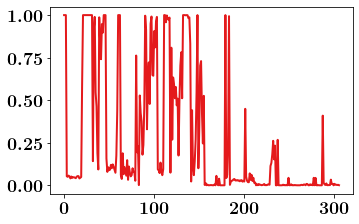

In [10]:
plt.plot(pipe.predict_proba(X_train_original)[:,0])

In [11]:
def normalize_scores(scores,log_prob=False):
    
    if log_prob:
        scores = np.log(np.abs(scores - 1.1 * np.amax(scores)))
    
    norm_mean = np.mean(scores[:,0])
    norm_std = np.std(scores[:,0])
    
    scores = (scores - norm_mean) / norm_std
    
    [print(normaltest(scores[:,i])) for i in range(scores.shape[1])]
    [print(np.std(scores[:,i]), np.mean(scores[:,i])) for i in range(scores.shape[1])]
    
    return scores

In [12]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

NameError: name 'Y_cnn_valid_pred' is not defined

In [15]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization

from ML_Train.Custom_Layers import Dropout_Live

def build_hp_classifier(hp):
    
    mlp = Sequential()
    mlp.add(Input(shape=max_fft + DoE_shape))
    mlp.add(Flatten())
    
    for i in range(hp.Int('hidden_layers', 2, 5, step=1)):
        mlp.add(Dense(hp.Int('filters_' + str(i), 8, 256, step=8), activation='relu'))
        mlp.add(BatchNormalization())
        mlp.add(Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1)))
        
    mlp.add(Dense(2,activation='softmax'))
    
    mlp.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
        
    return mlp

In [16]:
pca = PCA(n_components=12)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)


tuner = kt.Hyperband(
    build_hp_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=4,
    directory='mlp_fft_classifier',
    project_name='mlp_fft_classifier')

tuner.search(X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project mlp_fft_classifier/mlp_fft_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from mlp_fft_classifier/mlp_fft_classifier/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [17]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


In [18]:

loss = model.fit(
            X_train,np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
            validation_data=(X_valid,np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=40,
            verbose=1)

Y_mlp_valid_pred = model.predict(X_valid)
Y_mlp_train_pred = model.predict(X_train)

Y_mlp_train_pred = np.argmax(Y_mlp_train_pred,axis=1)
Y_mlp_valid_pred = np.argmax(Y_mlp_valid_pred,axis=1)

Train on 306 samples, validate on 151 samples
Epoch 1/40
306/306 [==============================] - ETA: 5s - loss: 1.0995 - accuracy: 0.43 - 1s 3ms/sample - loss: 0.7873 - accuracy: 0.6601 - val_loss: 0.7093 - val_accuracy: 0.4106
Epoch 2/40
306/306 [==============================] - ETA: 0s - loss: 0.9536 - accuracy: 0.68 - 0s 188us/sample - loss: 0.5877 - accuracy: 0.7222 - val_loss: 0.9485 - val_accuracy: 0.4172
Epoch 3/40
306/306 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.87 - 0s 187us/sample - loss: 0.4600 - accuracy: 0.7908 - val_loss: 1.1322 - val_accuracy: 0.4702
Epoch 4/40
306/306 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.84 - 0s 174us/sample - loss: 0.3207 - accuracy: 0.8464 - val_loss: 1.2834 - val_accuracy: 0.4768
Epoch 5/40
306/306 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.93 - 0s 193us/sample - loss: 0.2388 - accuracy: 0.8922 - val_loss: 1.7244 - val_accuracy: 0.4834
Epoch 6/40
306/3

In [19]:

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 131)               0         
_________________________________________________________________
dense (Dense)                (None, 248)               32736     
_________________________________________________________________
batch_normalization (BatchNo (None, 248)               992       
_________________________________________________________________
dropout (Dropout)            (None, 248)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 104)               25896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 104)               416       
_________________________________________________________________
dropout_1 (Dropout)          (None, 104)               0

No handles with labels found to put in legend.


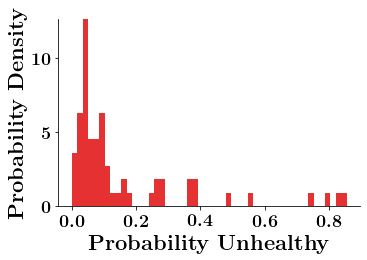

No handles with labels found to put in legend.


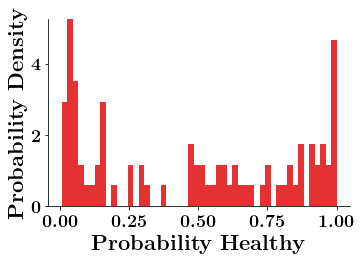

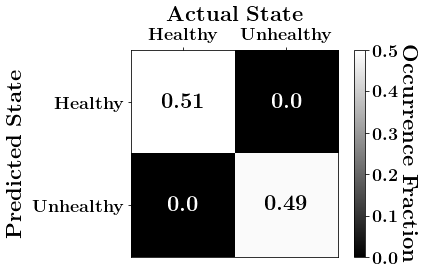

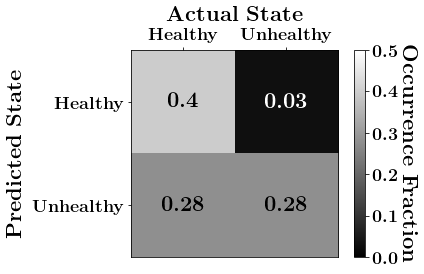

(1.0, 1.0, 1.0)
(0.74573055028463, 0.5882352941176471, 0.9032258064516129)


In [20]:
genplt.plot_histogram(model.predict(X_valid_unhealthy)[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy)[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_mlp_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_mlp_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [21]:

conf_matrix_mlp_valid = confusion_matrix(Y_valid, Y_mlp_valid_pred)
accuracy_mlp_valid = np.sum(np.diagonal(conf_matrix_mlp_valid)) / np.sum(conf_matrix_mlp_valid)
print(conf_matrix_mlp_valid)
print(accuracy_mlp_valid)

conf_matrix_mlp_train = confusion_matrix(Y_train, Y_mlp_train_pred)
accuracy_mlp_train = np.sum(np.diagonal(conf_matrix_mlp_train)) / np.sum(conf_matrix_mlp_train)
print(conf_matrix_mlp_train)
print(accuracy_mlp_train)

[[60  5]
 [43 43]]
0.6821192052980133
[[156   0]
 [  0 150]]
1.0


In [31]:
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, UpSampling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live, Sampling

def build_classifier(
                   hp
                   ):
    inputs = Input(shape=(max_fft + DoE_shape,1))
    x = inputs
    
    for i in range(hp.Int('filters', 2, 5, step=1)):
        x = Conv1D(filters=hp.Int('filters_' + str(i), 4, 64, step=4), 
                           kernel_size=hp.Int('kernels_' + str(i), 3, 19, step=4), 
                           strides=1, 
                           activation='relu', 
                           padding='same',
                           dilation_rate=1)(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_rate_' + str(i), 0.0, 0.5, step=0.1))(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    for i in range(hp.Int('dense_layers', 1, 3, step=1)):
        x = Dense(hp.Int('dense_' + str(i), 8, 256, step=8), activation='selu')(x)

    x = Dense(2,activation='softmax')(x)
    
    cnn_classifier = Model(
                            inputs=[inputs],
                            outputs=[x])
    
    cnn_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(
      hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='categorical_crossentropy', 
    metrics=['accuracy'])
     
    
    return cnn_classifier


In [32]:

tuner = kt.Hyperband(
    build_classifier,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    directory='cnn_fft_classifier',
    project_name='cnn_fft_classifier')

tuner.search(X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
             validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

INFO:tensorflow:Reloading Oracle from existing project cnn_fft_classifier/cnn_fft_classifier/oracle.json
Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 11s - loss: 0.6187 - accuracy: 0.656 - 2s 5ms/sample - loss: 0.7075 - accuracy: 0.6307 - val_loss: 0.7110 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8392 - accuracy: 0.56 - 0s 180us/sample - loss: 0.6055 - accuracy: 0.6797 - val_loss: 0.7248 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.7615 - accuracy: 0.37 - 1s 4ms/sample - loss: 0.6993 - accuracy: 0.5261 - val_loss: 0.7127 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.71 - 0s 272us/sample - loss: 0.6219 - accuracy: 0.6176 - val_loss: 0.7052 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.4752 - accuracy: 0.50 - ETA: 0s - loss: 2.5867 - accuracy: 0.57 - 1s 3ms/sample - loss: 2.6122 - accuracy: 0.5686 - val_loss: 0.8885 - val_accuracy: 0.5298
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.9183 - accuracy: 0.68 - 0s 279us/sample - loss: 1.6324 - accuracy: 0.6765 - val_loss: 0.8047 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.8934 - accuracy: 0.50 - 1s 4ms/sample - loss: 1.7297 - accuracy: 0.6013 - val_loss: 0.7689 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 2.2261 - accuracy: 0.50 - 0s 225us/sample - loss: 0.9571 - accuracy: 0.6569 - val_loss: 0.7835 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.0742 - accuracy: 0.37 - 1s 3ms/sample - loss: 0.8165 - accuracy: 0.4444 - val_loss: 0.6740 - val_accuracy: 0.6887
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.65 - 0s 170us/sample - loss: 0.6118 - accuracy: 0.6863 - val_loss: 0.6845 - val_accuracy: 0.5629


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2761 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.3300 - accuracy: 0.5621 - val_loss: 0.7226 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2235 - accuracy: 0.68 - 0s 200us/sample - loss: 1.1937 - accuracy: 0.5359 - val_loss: 0.7126 - val_accuracy: 0.4106


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.4262 - accuracy: 0.43 - 1s 4ms/sample - loss: 2.8054 - accuracy: 0.5719 - val_loss: 1.1783 - val_accuracy: 0.3841
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2568 - accuracy: 0.56 - 0s 243us/sample - loss: 1.0149 - accuracy: 0.7320 - val_loss: 1.0824 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.6929 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.8885 - accuracy: 0.5850 - val_loss: 0.8272 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9160 - accuracy: 0.68 - 0s 238us/sample - loss: 0.9574 - accuracy: 0.7320 - val_loss: 0.9523 - val_accuracy: 0.6026


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.7866 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.8436 - accuracy: 0.5458 - val_loss: 0.7353 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.75 - 0s 184us/sample - loss: 0.6137 - accuracy: 0.6732 - val_loss: 0.7401 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.6642 - accuracy: 0.59 - 1s 4ms/sample - loss: 1.2035 - accuracy: 0.5817 - val_loss: 1.2001 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7741 - accuracy: 0.65 - 0s 259us/sample - loss: 0.9318 - accuracy: 0.5686 - val_loss: 0.6608 - val_accuracy: 0.7550


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.8408 - accuracy: 0.50 - 1s 4ms/sample - loss: 0.6597 - accuracy: 0.6471 - val_loss: 0.6920 - val_accuracy: 0.3046
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.81 - 0s 289us/sample - loss: 0.4658 - accuracy: 0.7876 - val_loss: 0.6963 - val_accuracy: 0.5033


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.9499 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.6286 - accuracy: 0.6601 - val_loss: 0.6920 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.3108 - accuracy: 0.84 - 0s 193us/sample - loss: 0.3579 - accuracy: 0.8203 - val_loss: 0.7081 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.1956 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.9746 - accuracy: 0.5359 - val_loss: 1.0128 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.59 - 0s 183us/sample - loss: 1.0645 - accuracy: 0.6013 - val_loss: 0.8516 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.7561 - accuracy: 0.62 - 1s 3ms/sample - loss: 1.0987 - accuracy: 0.6569 - val_loss: 0.7951 - val_accuracy: 0.6424
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.78 - 0s 181us/sample - loss: 0.5876 - accuracy: 0.7614 - val_loss: 0.7990 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.8451 - accuracy: 0.46 - 1s 4ms/sample - loss: 1.0709 - accuracy: 0.4967 - val_loss: 0.6919 - val_accuracy: 0.3907
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.56 - 0s 246us/sample - loss: 0.7905 - accuracy: 0.5654 - val_loss: 0.6988 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.7559 - accuracy: 0.53 - ETA: 0s - loss: 0.7191 - accuracy: 0.54 - 1s 4ms/sample - loss: 0.7209 - accuracy: 0.5425 - val_loss: 0.6883 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.56 - ETA: 0s - loss: 0.6959 - accuracy: 0.55 - 0s 347us/sample - loss: 0.6960 - accuracy: 0.5523 - val_loss: 0.6876 - val_accuracy: 0.5894


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.6814 - accuracy: 0.31 - 1s 3ms/sample - loss: 1.3301 - accuracy: 0.5490 - val_loss: 0.7236 - val_accuracy: 0.6887
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.56 - 0s 196us/sample - loss: 0.7732 - accuracy: 0.6242 - val_loss: 0.7900 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.8452 - accuracy: 0.59 - 1s 4ms/sample - loss: 1.1756 - accuracy: 0.5686 - val_loss: 0.8160 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8273 - accuracy: 0.62 - 0s 203us/sample - loss: 0.6754 - accuracy: 0.6797 - val_loss: 0.8211 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 1.2035 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.0218 - accuracy: 0.5425 - val_loss: 0.6885 - val_accuracy: 0.5629
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0722 - accuracy: 0.56 - 0s 248us/sample - loss: 0.9651 - accuracy: 0.5686 - val_loss: 0.7125 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1760 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8707 - accuracy: 0.5654 - val_loss: 0.8020 - val_accuracy: 0.5894
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5230 - accuracy: 0.81 - 0s 167us/sample - loss: 0.5120 - accuracy: 0.7582 - val_loss: 0.8694 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.4877 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9907 - accuracy: 0.5294 - val_loss: 0.6982 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8114 - accuracy: 0.40 - 0s 196us/sample - loss: 0.7087 - accuracy: 0.6176 - val_loss: 0.7177 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.8491 - accuracy: 0.46 - ETA: 0s - loss: 1.0919 - accuracy: 0.56 - 1s 4ms/sample - loss: 1.0901 - accuracy: 0.5621 - val_loss: 0.6853 - val_accuracy: 0.6159
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5712 - accuracy: 0.68 - 0s 262us/sample - loss: 0.8396 - accuracy: 0.6307 - val_loss: 0.6811 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 1.1552 - accuracy: 0.65 - ETA: 0s - loss: 1.4245 - accuracy: 0.51 - 1s 5ms/sample - loss: 1.4250 - accuracy: 0.5000 - val_loss: 0.7368 - val_accuracy: 0.4834
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.2715 - accuracy: 0.43 - 0s 313us/sample - loss: 0.9925 - accuracy: 0.5458 - val_loss: 0.7318 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.9062 - accuracy: 0.59 - 1s 3ms/sample - loss: 0.8232 - accuracy: 0.5784 - val_loss: 0.7010 - val_accuracy: 0.3907
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8063 - accuracy: 0.50 - 0s 221us/sample - loss: 0.7664 - accuracy: 0.5882 - val_loss: 0.7722 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.7998 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.6970 - accuracy: 0.5948 - val_loss: 0.6951 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.81 - 0s 193us/sample - loss: 0.4728 - accuracy: 0.7680 - val_loss: 0.7004 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.1099 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.2203 - accuracy: 0.4216 - val_loss: 0.6916 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8817 - accuracy: 0.62 - 0s 278us/sample - loss: 1.0158 - accuracy: 0.5163 - val_loss: 0.6903 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.8228 - accuracy: 0.50 - 1s 3ms/sample - loss: 0.7150 - accuracy: 0.6471 - val_loss: 0.7083 - val_accuracy: 0.4106
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4231 - accuracy: 0.81 - 0s 220us/sample - loss: 0.4984 - accuracy: 0.7549 - val_loss: 0.7415 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 0.9125 - accuracy: 0.59 - ETA: 0s - loss: 1.3228 - accuracy: 0.56 - 1s 4ms/sample - loss: 1.3116 - accuracy: 0.5654 - val_loss: 0.6921 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0709 - accuracy: 0.46 - 0s 252us/sample - loss: 0.9448 - accuracy: 0.5163 - val_loss: 0.6981 - val_accuracy: 0.3510


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.0499 - accuracy: 0.37 - 1s 4ms/sample - loss: 1.5457 - accuracy: 0.5065 - val_loss: 0.7133 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.7083 - accuracy: 0.43 - 0s 214us/sample - loss: 0.9583 - accuracy: 0.5719 - val_loss: 0.7381 - val_accuracy: 0.3377


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.2100 - accuracy: 0.31 - 1s 3ms/sample - loss: 0.9802 - accuracy: 0.4837 - val_loss: 0.6818 - val_accuracy: 0.4768
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8457 - accuracy: 0.53 - 0s 253us/sample - loss: 0.7963 - accuracy: 0.5556 - val_loss: 0.6912 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9445 - accuracy: 0.65 - 1s 3ms/sample - loss: 0.6390 - accuracy: 0.6863 - val_loss: 0.7611 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.96 - 0s 198us/sample - loss: 0.3865 - accuracy: 0.8399 - val_loss: 0.8227 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.0208 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9491 - accuracy: 0.5654 - val_loss: 0.7061 - val_accuracy: 0.4172
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1160 - accuracy: 0.56 - 0s 228us/sample - loss: 0.8734 - accuracy: 0.6242 - val_loss: 0.7112 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.7284 - accuracy: 0.40 - 1s 3ms/sample - loss: 0.7353 - accuracy: 0.5948 - val_loss: 0.6953 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5139 - accuracy: 0.71 - 0s 232us/sample - loss: 0.5033 - accuracy: 0.7320 - val_loss: 0.6973 - val_accuracy: 0.6026


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 1.0816 - accuracy: 0.50 - ETA: 0s - loss: 1.0988 - accuracy: 0.50 - 1s 5ms/sample - loss: 1.0768 - accuracy: 0.5131 - val_loss: 0.6897 - val_accuracy: 0.5828
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8019 - accuracy: 0.68 - 0s 251us/sample - loss: 0.8377 - accuracy: 0.6176 - val_loss: 0.6948 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 0.8228 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.0550 - accuracy: 0.5850 - val_loss: 0.8940 - val_accuracy: 0.5762
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.65 - 0s 219us/sample - loss: 0.9343 - accuracy: 0.5654 - val_loss: 0.9535 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.1080 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8369 - accuracy: 0.5131 - val_loss: 0.7058 - val_accuracy: 0.7417
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7259 - accuracy: 0.56 - 0s 161us/sample - loss: 0.6636 - accuracy: 0.6405 - val_loss: 0.7143 - val_accuracy: 0.6689


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.3658 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.9430 - accuracy: 0.5784 - val_loss: 0.7057 - val_accuracy: 0.5166
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6371 - accuracy: 0.53 - 0s 198us/sample - loss: 0.6140 - accuracy: 0.6830 - val_loss: 0.7223 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0191 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.9581 - accuracy: 0.6569 - val_loss: 0.7154 - val_accuracy: 0.5033
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.75 - 0s 237us/sample - loss: 0.7686 - accuracy: 0.7582 - val_loss: 0.7251 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 2.1689 - accuracy: 0.31 - 1s 3ms/sample - loss: 1.1796 - accuracy: 0.5915 - val_loss: 0.6922 - val_accuracy: 0.5563
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8326 - accuracy: 0.59 - 0s 248us/sample - loss: 0.7241 - accuracy: 0.6601 - val_loss: 0.7283 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.7845 - accuracy: 0.62 - 1s 2ms/sample - loss: 1.8604 - accuracy: 0.5817 - val_loss: 1.1217 - val_accuracy: 0.4503
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 2.2643 - accuracy: 0.59 - 0s 165us/sample - loss: 0.9546 - accuracy: 0.6569 - val_loss: 0.9744 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 0.4945 - accuracy: 0.78 - 1s 2ms/sample - loss: 0.6118 - accuracy: 0.7026 - val_loss: 0.7136 - val_accuracy: 0.5232
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.3881 - accuracy: 0.81 - 0s 198us/sample - loss: 0.5101 - accuracy: 0.7843 - val_loss: 0.7169 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 0.8340 - accuracy: 0.62 - 1s 3ms/sample - loss: 2.9483 - accuracy: 0.6013 - val_loss: 0.8560 - val_accuracy: 0.5232
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 2.5073 - accuracy: 0.56 - 0s 278us/sample - loss: 1.5321 - accuracy: 0.6732 - val_loss: 0.7555 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 0.7851 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.8121 - accuracy: 0.5098 - val_loss: 0.6881 - val_accuracy: 0.5232
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.56 - 0s 313us/sample - loss: 0.7203 - accuracy: 0.5392 - val_loss: 0.6878 - val_accuracy: 0.5629


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.9739 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.8269 - accuracy: 0.6373 - val_loss: 0.7333 - val_accuracy: 0.3775
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.68 - 0s 196us/sample - loss: 0.6236 - accuracy: 0.6830 - val_loss: 0.7904 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 1.0303 - accuracy: 0.46 - ETA: 0s - loss: 1.1878 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.1497 - accuracy: 0.4869 - val_loss: 0.7080 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8638 - accuracy: 0.65 - 0s 252us/sample - loss: 0.9829 - accuracy: 0.5850 - val_loss: 0.7199 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 0.9532 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7744 - accuracy: 0.5686 - val_loss: 0.7036 - val_accuracy: 0.5695
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4813 - accuracy: 0.71 - 0s 206us/sample - loss: 0.5049 - accuracy: 0.7712 - val_loss: 0.7242 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.1356 - accuracy: 0.34 - 1s 2ms/sample - loss: 0.7709 - accuracy: 0.5327 - val_loss: 0.7100 - val_accuracy: 0.3444
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4281 - accuracy: 0.78 - 0s 238us/sample - loss: 0.5672 - accuracy: 0.6928 - val_loss: 0.7210 - val_accuracy: 0.3775


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.2752 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.0053 - accuracy: 0.5327 - val_loss: 0.9773 - val_accuracy: 0.6225
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.68 - 0s 227us/sample - loss: 1.0216 - accuracy: 0.5523 - val_loss: 0.9681 - val_accuracy: 0.4437
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.7628 - accuracy: 0.59 - 0s 222us/sample - loss: 0.7626 - accuracy: 0.5588 - val_loss: 0.8175 - val_accuracy: 0.4437
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.65 - 0s 221us/sample - loss: 0.5881 - accuracy: 0.7026 - val_loss: 0.7817 - val_accuracy: 0.4305
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.62 - 0s 208us/sample - loss: 0.5123 - accuracy: 0.7353 - val_loss: 0.9567 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 0.7541 - accuracy: 0.62 - 1s 3ms/sample - loss: 2.8854 - accuracy: 0.5686 - val_loss: 0.8317 - val_accuracy: 0.4040
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.84 - 0s 272us/sample - loss: 1.2237 - accuracy: 0.7288 - val_loss: 0.7819 - val_accuracy: 0.5232
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.68 - 0s 214us/sample - loss: 0.6149 - accuracy: 0.7614 - val_loss: 0.8193 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 0.8703 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.6867 - accuracy: 0.6209 - val_loss: 0.6993 - val_accuracy: 0.4371
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.3851 - accuracy: 0.78 - 0s 241us/sample - loss: 0.4882 - accuracy: 0.7549 - val_loss: 0.7119 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 0.9005 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.2074 - accuracy: 0.5229 - val_loss: 1.0895 - val_accuracy: 0.5960
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.56 - 0s 293us/sample - loss: 0.9873 - accuracy: 0.5229 - val_loss: 1.1397 - val_accuracy: 0.6225


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 0.7272 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.7950 - accuracy: 0.6013 - val_loss: 0.7103 - val_accuracy: 0.4106
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4646 - accuracy: 0.78 - 0s 242us/sample - loss: 0.4858 - accuracy: 0.7582 - val_loss: 0.7168 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 1.3661 - accuracy: 0.34 - ETA: 0s - loss: 1.0314 - accuracy: 0.50 - 1s 4ms/sample - loss: 1.0583 - accuracy: 0.5000 - val_loss: 0.7240 - val_accuracy: 0.4503
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.53 - 0s 217us/sample - loss: 0.9057 - accuracy: 0.5261 - val_loss: 0.7033 - val_accuracy: 0.4371
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.8395 - accuracy: 0.56 - 0s 212us/sample - loss: 0.7508 - accuracy: 0.5882 - val_loss: 0.7732 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 2.1864 - accuracy: 0.56 - 1s 4ms/sample - loss: 1.1921 - accuracy: 0.5425 - val_loss: 0.7267 - val_accuracy: 0.4238
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2133 - accuracy: 0.65 - 0s 249us/sample - loss: 0.8214 - accuracy: 0.6405 - val_loss: 0.7359 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 0.8637 - accuracy: 0.43 - ETA: 0s - loss: 0.9617 - accuracy: 0.46 - 1s 4ms/sample - loss: 0.9458 - accuracy: 0.4706 - val_loss: 0.6999 - val_accuracy: 0.4305
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.62 - ETA: 0s - loss: 0.8695 - accuracy: 0.52 - 0s 352us/sample - loss: 0.8689 - accuracy: 0.5229 - val_loss: 0.7077 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 0.8676 - accuracy: 0.46 - 1s 4ms/sample - loss: 0.8038 - accuracy: 0.5425 - val_loss: 0.6953 - val_accuracy: 0.4437
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7661 - accuracy: 0.59 - 0s 299us/sample - loss: 0.6495 - accuracy: 0.6275 - val_loss: 0.6901 - val_accuracy: 0.4768
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.65 - 0s 299us/sample - loss: 0.6511 - accuracy: 0.6732 - val_loss: 0.6882 - val_accuracy: 0.7219
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.71 - 0s 248us/sample - loss: 0.5124 - accuracy: 0.7484 - val_loss: 0.6961 - val_accuracy: 0.3709


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 8s - loss: 0.8590 - accuracy: 0.43 - 1s 4ms/sample - loss: 1.0559 - accuracy: 0.4967 - val_loss: 0.6941 - val_accuracy: 0.5166
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.62 - 0s 308us/sample - loss: 0.9366 - accuracy: 0.5523 - val_loss: 0.6902 - val_accuracy: 0.5695
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.8268 - accuracy: 0.59 - 0s 237us/sample - loss: 0.9398 - accuracy: 0.4869 - val_loss: 0.7110 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.2507 - accuracy: 0.46 - 1s 4ms/sample - loss: 2.0963 - accuracy: 0.4510 - val_loss: 0.7789 - val_accuracy: 0.4702
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7644 - accuracy: 0.75 - 0s 215us/sample - loss: 1.0033 - accuracy: 0.5980 - val_loss: 0.7716 - val_accuracy: 0.3974
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.68 - 0s 279us/sample - loss: 0.8011 - accuracy: 0.6046 - val_loss: 0.7458 - val_accuracy: 0.4967
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.68 - 0s 222us/sample - loss: 0.6252 - accuracy: 0.6797 - val_loss: 0.7888 - val_accuracy: 0.3907


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 2.2825 - accuracy: 0.53 - 1s 2ms/sample - loss: 3.6379 - accuracy: 0.6176 - val_loss: 1.0242 - val_accuracy: 0.4371
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 4.4306 - accuracy: 0.56 - 0s 196us/sample - loss: 1.8008 - accuracy: 0.7026 - val_loss: 0.9680 - val_accuracy: 0.4503
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.9317 - accuracy: 0.68 - 0s 204us/sample - loss: 0.4981 - accuracy: 0.8529 - val_loss: 0.9818 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.0359 - accuracy: 0.46 - 1s 3ms/sample - loss: 2.7947 - accuracy: 0.5588 - val_loss: 0.9198 - val_accuracy: 0.6159
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5449 - accuracy: 0.68 - 0s 188us/sample - loss: 1.1097 - accuracy: 0.6699 - val_loss: 1.0106 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 0.9884 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.8510 - accuracy: 0.5131 - val_loss: 0.6973 - val_accuracy: 0.4901
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.71 - 0s 214us/sample - loss: 0.6273 - accuracy: 0.6601 - val_loss: 0.7004 - val_accuracy: 0.2914


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 0.9449 - accuracy: 0.53 - 1s 2ms/sample - loss: 0.8330 - accuracy: 0.4837 - val_loss: 0.7042 - val_accuracy: 0.4901
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7689 - accuracy: 0.46 - 0s 164us/sample - loss: 0.8077 - accuracy: 0.5098 - val_loss: 0.7158 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.5246 - accuracy: 0.43 - 1s 4ms/sample - loss: 1.0588 - accuracy: 0.5490 - val_loss: 0.6860 - val_accuracy: 0.6026
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.53 - 0s 216us/sample - loss: 0.6847 - accuracy: 0.6405 - val_loss: 0.6897 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 2.7100 - accuracy: 0.43 - 1s 2ms/sample - loss: 1.2209 - accuracy: 0.5784 - val_loss: 0.7324 - val_accuracy: 0.4503
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.75 - 0s 171us/sample - loss: 0.6605 - accuracy: 0.7190 - val_loss: 0.7448 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 0.9590 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.0831 - accuracy: 0.5523 - val_loss: 0.9026 - val_accuracy: 0.5497
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8381 - accuracy: 0.56 - 0s 224us/sample - loss: 0.6715 - accuracy: 0.6667 - val_loss: 0.7932 - val_accuracy: 0.3841
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.5299 - accuracy: 0.78 - 0s 217us/sample - loss: 0.5765 - accuracy: 0.6895 - val_loss: 1.0443 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.0469 - accuracy: 0.43 - 1s 4ms/sample - loss: 0.8508 - accuracy: 0.5980 - val_loss: 0.7144 - val_accuracy: 0.5298
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.71 - 0s 209us/sample - loss: 0.6350 - accuracy: 0.6699 - val_loss: 0.7327 - val_accuracy: 0.4040


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.0227 - accuracy: 0.53 - 1s 2ms/sample - loss: 2.0017 - accuracy: 0.5980 - val_loss: 0.7145 - val_accuracy: 0.4437
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.71 - 0s 153us/sample - loss: 0.9740 - accuracy: 0.7124 - val_loss: 0.7824 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.8243 - accuracy: 0.37 - 1s 3ms/sample - loss: 1.0442 - accuracy: 0.5392 - val_loss: 0.6958 - val_accuracy: 0.5430
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.62 - 0s 219us/sample - loss: 0.7354 - accuracy: 0.6340 - val_loss: 0.6986 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.2062 - accuracy: 0.50 - 1s 2ms/sample - loss: 3.5942 - accuracy: 0.5458 - val_loss: 0.8795 - val_accuracy: 0.4967
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.6063 - accuracy: 0.50 - 0s 231us/sample - loss: 0.8172 - accuracy: 0.6732 - val_loss: 0.7549 - val_accuracy: 0.5430
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.71 - 0s 177us/sample - loss: 0.5743 - accuracy: 0.7222 - val_loss: 0.7649 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 0.8949 - accuracy: 0.59 - 1s 3ms/sample - loss: 0.8208 - accuracy: 0.6307 - val_loss: 0.6867 - val_accuracy: 0.5695
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.71 - 0s 216us/sample - loss: 0.6170 - accuracy: 0.7190 - val_loss: 0.6844 - val_accuracy: 0.5695
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.5469 - accuracy: 0.68 - 0s 218us/sample - loss: 0.5249 - accuracy: 0.7712 - val_loss: 0.6818 - val_accuracy: 0.5695
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.65 - 0s 215us/sample - loss: 0.4730 - accuracy: 0.7647 - val_loss: 0.6777 - val_accuracy: 0.5695
Epoch 9/10
306/306 [==============================] - ETA: 0s - loss: 0.5233 - accuracy: 0.68 - 0s 285us/sample - loss: 0.4361 - accuracy: 0.7908 - val_loss: 0.6801 - val_accuracy: 0.6225


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 6s - loss: 0.6315 - accuracy: 0.65 - 1s 3ms/sample - loss: 0.8823 - accuracy: 0.5850 - val_loss: 0.7217 - val_accuracy: 0.4305
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9072 - accuracy: 0.50 - 0s 295us/sample - loss: 0.9420 - accuracy: 0.5196 - val_loss: 0.6973 - val_accuracy: 0.4570
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.8927 - accuracy: 0.34 - ETA: 0s - loss: 0.8039 - accuracy: 0.48 - 0s 259us/sample - loss: 0.8071 - accuracy: 0.4967 - val_loss: 0.7119 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 1.1489 - accuracy: 0.43 - 1s 2ms/sample - loss: 2.6659 - accuracy: 0.6046 - val_loss: 1.3312 - val_accuracy: 0.4106
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 2.2732 - accuracy: 0.68 - 0s 148us/sample - loss: 1.1193 - accuracy: 0.7353 - val_loss: 1.3525 - val_accuracy: 0.4040


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 2.3314 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.1200 - accuracy: 0.5850 - val_loss: 0.7001 - val_accuracy: 0.4238
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.9077 - accuracy: 0.68 - 0s 282us/sample - loss: 0.7293 - accuracy: 0.6765 - val_loss: 0.6982 - val_accuracy: 0.4371
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.75 - 0s 283us/sample - loss: 0.5648 - accuracy: 0.7026 - val_loss: 0.6987 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.3125 - accuracy: 0.43 - 1s 3ms/sample - loss: 0.7881 - accuracy: 0.6013 - val_loss: 0.6981 - val_accuracy: 0.4768
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.71 - 0s 230us/sample - loss: 0.6379 - accuracy: 0.6438 - val_loss: 0.7004 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 6s - loss: 1.2173 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.8886 - accuracy: 0.5588 - val_loss: 0.7018 - val_accuracy: 0.4371
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.68 - 0s 268us/sample - loss: 0.8232 - accuracy: 0.5588 - val_loss: 0.7148 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 0.9650 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.9844 - accuracy: 0.5261 - val_loss: 0.7142 - val_accuracy: 0.4437
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0673 - accuracy: 0.46 - 0s 243us/sample - loss: 0.8744 - accuracy: 0.5523 - val_loss: 0.7154 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 3s - loss: 1.0836 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.5206 - accuracy: 0.4510 - val_loss: 0.6630 - val_accuracy: 0.5828
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.8880 - accuracy: 0.34 - 0s 195us/sample - loss: 1.0248 - accuracy: 0.5588 - val_loss: 0.6603 - val_accuracy: 0.6093
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.9291 - accuracy: 0.46 - 0s 158us/sample - loss: 0.7524 - accuracy: 0.6373 - val_loss: 0.6674 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 6s - loss: 0.7310 - accuracy: 0.65 - 1s 4ms/sample - loss: 0.9326 - accuracy: 0.5850 - val_loss: 0.7126 - val_accuracy: 0.5497
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.59 - 0s 220us/sample - loss: 0.9840 - accuracy: 0.6013 - val_loss: 0.8004 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 6s - loss: 1.0418 - accuracy: 0.50 - 1s 4ms/sample - loss: 2.0324 - accuracy: 0.5033 - val_loss: 0.8297 - val_accuracy: 0.5762
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.78 - 0s 231us/sample - loss: 0.9818 - accuracy: 0.6438 - val_loss: 1.7267 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.1105 - accuracy: 0.40 - 1s 3ms/sample - loss: 1.3986 - accuracy: 0.6111 - val_loss: 0.7816 - val_accuracy: 0.5497
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.62 - 0s 181us/sample - loss: 0.6662 - accuracy: 0.7222 - val_loss: 0.8420 - val_accuracy: 0.5497


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 0.9112 - accuracy: 0.68 - 1s 3ms/sample - loss: 1.2390 - accuracy: 0.5425 - val_loss: 0.6812 - val_accuracy: 0.5298
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.9992 - accuracy: 0.46 - 0s 239us/sample - loss: 1.0399 - accuracy: 0.5686 - val_loss: 0.6875 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 7s - loss: 1.1316 - accuracy: 0.40 - 1s 4ms/sample - loss: 0.9324 - accuracy: 0.5621 - val_loss: 0.7076 - val_accuracy: 0.5099
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.9408 - accuracy: 0.43 - 0s 225us/sample - loss: 0.6681 - accuracy: 0.6405 - val_loss: 0.7193 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 3s - loss: 1.1359 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.0705 - accuracy: 0.4869 - val_loss: 0.7120 - val_accuracy: 0.6159
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.50 - 0s 155us/sample - loss: 0.8449 - accuracy: 0.5327 - val_loss: 0.7250 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.4355 - accuracy: 0.50 - 1s 3ms/sample - loss: 2.5836 - accuracy: 0.4771 - val_loss: 1.6949 - val_accuracy: 0.3775
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.1339 - accuracy: 0.53 - 0s 303us/sample - loss: 1.3280 - accuracy: 0.5327 - val_loss: 1.1393 - val_accuracy: 0.5099
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.9613 - accuracy: 0.56 - 0s 294us/sample - loss: 0.6518 - accuracy: 0.6765 - val_loss: 0.8993 - val_accuracy: 0.5695
Epoch 14/30
306/306 [==============================] - ETA: 0s - loss: 0.8231 - accuracy: 0.59 - 0s 276us/sample - loss: 0.6192 - accuracy: 0.6993 - val_loss: 0.8250 - val_accuracy: 0.6159
Epoch 15/30
306/306 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.90 - 0s 227us/sample - loss: 0.6266 - accuracy: 0.7059 - val_loss: 0.8997 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.5659 - accuracy: 0.34 - 1s 2ms/sample - loss: 1.1993 - accuracy: 0.5098 - val_loss: 0.7149 - val_accuracy: 0.4437
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.8943 - accuracy: 0.59 - 0s 188us/sample - loss: 0.9005 - accuracy: 0.5719 - val_loss: 0.7402 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 8s - loss: 0.8820 - accuracy: 0.37 - 1s 4ms/sample - loss: 2.2622 - accuracy: 0.5098 - val_loss: 0.8923 - val_accuracy: 0.4901
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.2147 - accuracy: 0.56 - 0s 342us/sample - loss: 0.9653 - accuracy: 0.5327 - val_loss: 0.6954 - val_accuracy: 0.5563
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7895 - accuracy: 0.59 - 0s 271us/sample - loss: 0.9029 - accuracy: 0.5980 - val_loss: 1.0435 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 7s - loss: 1.0403 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.2242 - accuracy: 0.5229 - val_loss: 0.7117 - val_accuracy: 0.4702
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.1949 - accuracy: 0.62 - 0s 314us/sample - loss: 0.9836 - accuracy: 0.6144 - val_loss: 0.6830 - val_accuracy: 0.5497
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 1.1297 - accuracy: 0.68 - 0s 253us/sample - loss: 1.1092 - accuracy: 0.6111 - val_loss: 0.7840 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 7s - loss: 0.7909 - accuracy: 0.50 - 1s 4ms/sample - loss: 0.8045 - accuracy: 0.4412 - val_loss: 0.6908 - val_accuracy: 0.5298
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.62 - 0s 230us/sample - loss: 0.6829 - accuracy: 0.5621 - val_loss: 0.6908 - val_accuracy: 0.5099


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 7s - loss: 0.8516 - accuracy: 0.65 - ETA: 0s - loss: 1.1998 - accuracy: 0.57 - 1s 4ms/sample - loss: 1.2018 - accuracy: 0.5654 - val_loss: 0.6917 - val_accuracy: 0.5894
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.59 - ETA: 0s - loss: 0.7977 - accuracy: 0.60 - 0s 268us/sample - loss: 0.8026 - accuracy: 0.6013 - val_loss: 0.7523 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 7s - loss: 0.8324 - accuracy: 0.65 - 1s 4ms/sample - loss: 1.1099 - accuracy: 0.4869 - val_loss: 0.6938 - val_accuracy: 0.4238
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.75 - 0s 304us/sample - loss: 0.9488 - accuracy: 0.5523 - val_loss: 0.6980 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.8434 - accuracy: 0.59 - 1s 4ms/sample - loss: 0.9597 - accuracy: 0.5261 - val_loss: 0.7029 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.65 - ETA: 0s - loss: 0.8155 - accuracy: 0.56 - 0s 357us/sample - loss: 0.8080 - accuracy: 0.5654 - val_loss: 0.6889 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.9674 - accuracy: 0.50 - 1s 4ms/sample - loss: 0.9677 - accuracy: 0.5425 - val_loss: 0.6878 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.62 - 0s 219us/sample - loss: 0.9170 - accuracy: 0.5817 - val_loss: 0.6873 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.8009 - accuracy: 0.31 - 1s 4ms/sample - loss: 1.1337 - accuracy: 0.5327 - val_loss: 0.7506 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.65 - 0s 227us/sample - loss: 0.7151 - accuracy: 0.6765 - val_loss: 0.7786 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 0.9910 - accuracy: 0.59 - ETA: 0s - loss: 0.9882 - accuracy: 0.53 - 1s 5ms/sample - loss: 0.9748 - accuracy: 0.5327 - val_loss: 0.7053 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.1387 - accuracy: 0.50 - 0s 252us/sample - loss: 0.8788 - accuracy: 0.4967 - val_loss: 0.7107 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.1569 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.2775 - accuracy: 0.5817 - val_loss: 0.7007 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5882 - accuracy: 0.78 - 0s 241us/sample - loss: 0.6848 - accuracy: 0.7516 - val_loss: 0.9421 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.1686 - accuracy: 0.37 - 1s 4ms/sample - loss: 0.9151 - accuracy: 0.6242 - val_loss: 0.8146 - val_accuracy: 0.4636
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7106 - accuracy: 0.78 - 0s 222us/sample - loss: 0.6874 - accuracy: 0.6895 - val_loss: 0.9612 - val_accuracy: 0.3974


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.2892 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9770 - accuracy: 0.5686 - val_loss: 0.7133 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.62 - 0s 277us/sample - loss: 0.6316 - accuracy: 0.6797 - val_loss: 0.7328 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.7882 - accuracy: 0.59 - 1s 4ms/sample - loss: 0.9941 - accuracy: 0.5425 - val_loss: 0.7257 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.65 - 0s 244us/sample - loss: 0.7504 - accuracy: 0.5882 - val_loss: 0.7150 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.9798 - accuracy: 0.50 - 1s 4ms/sample - loss: 0.9579 - accuracy: 0.5686 - val_loss: 0.7050 - val_accuracy: 0.3576
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.3421 - accuracy: 0.40 - 0s 288us/sample - loss: 0.9696 - accuracy: 0.5686 - val_loss: 0.7104 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.1935 - accuracy: 0.50 - 1s 2ms/sample - loss: 1.3788 - accuracy: 0.6111 - val_loss: 0.9617 - val_accuracy: 0.4570
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7310 - accuracy: 0.65 - 0s 195us/sample - loss: 0.8534 - accuracy: 0.7157 - val_loss: 0.8361 - val_accuracy: 0.3642


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.7439 - accuracy: 0.71 - 1s 4ms/sample - loss: 1.1790 - accuracy: 0.5654 - val_loss: 0.7203 - val_accuracy: 0.4172
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.78 - 0s 258us/sample - loss: 0.7949 - accuracy: 0.6536 - val_loss: 0.7106 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.2810 - accuracy: 0.34 - 1s 4ms/sample - loss: 1.3021 - accuracy: 0.4902 - val_loss: 0.7013 - val_accuracy: 0.4503
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.7058 - accuracy: 0.43 - 0s 215us/sample - loss: 1.0665 - accuracy: 0.5392 - val_loss: 0.7158 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 0.8825 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8434 - accuracy: 0.6111 - val_loss: 0.7723 - val_accuracy: 0.5695
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.62 - 0s 152us/sample - loss: 0.5994 - accuracy: 0.7255 - val_loss: 0.7701 - val_accuracy: 0.5563


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.1364 - accuracy: 0.43 - 1s 4ms/sample - loss: 1.1930 - accuracy: 0.6144 - val_loss: 0.7933 - val_accuracy: 0.5762
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.68 - 0s 233us/sample - loss: 0.8754 - accuracy: 0.6699 - val_loss: 0.8346 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.9112 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.1108 - accuracy: 0.5359 - val_loss: 0.6970 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9756 - accuracy: 0.43 - 0s 210us/sample - loss: 0.8122 - accuracy: 0.5784 - val_loss: 0.7037 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.1623 - accuracy: 0.43 - 1s 4ms/sample - loss: 0.7665 - accuracy: 0.6242 - val_loss: 0.7081 - val_accuracy: 0.5364
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4953 - accuracy: 0.75 - 0s 222us/sample - loss: 0.4858 - accuracy: 0.7908 - val_loss: 0.7151 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.7711 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.6929 - accuracy: 0.5948 - val_loss: 0.7000 - val_accuracy: 0.5232
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.65 - 0s 178us/sample - loss: 0.5455 - accuracy: 0.7320 - val_loss: 0.7265 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.8865 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.7265 - accuracy: 0.6340 - val_loss: 0.7069 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.4012 - accuracy: 0.81 - 0s 194us/sample - loss: 0.5182 - accuracy: 0.7288 - val_loss: 0.7305 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.2045 - accuracy: 0.50 - 1s 4ms/sample - loss: 0.9019 - accuracy: 0.4902 - val_loss: 0.7177 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7418 - accuracy: 0.65 - 0s 253us/sample - loss: 0.7415 - accuracy: 0.5556 - val_loss: 0.7265 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.6393 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.1597 - accuracy: 0.6536 - val_loss: 0.7738 - val_accuracy: 0.5430
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0930 - accuracy: 0.65 - 0s 274us/sample - loss: 0.5307 - accuracy: 0.8170 - val_loss: 0.7762 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.2375 - accuracy: 0.37 - 1s 4ms/sample - loss: 1.0733 - accuracy: 0.4902 - val_loss: 0.7109 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8249 - accuracy: 0.62 - 0s 338us/sample - loss: 1.0128 - accuracy: 0.5784 - val_loss: 0.7052 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.1707 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.9887 - accuracy: 0.5654 - val_loss: 0.6951 - val_accuracy: 0.5298
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9563 - accuracy: 0.53 - 0s 215us/sample - loss: 0.8869 - accuracy: 0.6536 - val_loss: 0.6979 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 0.7949 - accuracy: 0.53 - ETA: 0s - loss: 0.8116 - accuracy: 0.54 - 1s 4ms/sample - loss: 0.8009 - accuracy: 0.5523 - val_loss: 0.6942 - val_accuracy: 0.4702
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.7402 - accuracy: 0.56 - 0s 244us/sample - loss: 0.8221 - accuracy: 0.5392 - val_loss: 0.6998 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.7398 - accuracy: 0.62 - 1s 3ms/sample - loss: 0.8351 - accuracy: 0.5686 - val_loss: 0.7041 - val_accuracy: 0.4106
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.53 - 0s 287us/sample - loss: 0.6953 - accuracy: 0.6307 - val_loss: 0.7152 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 7s - loss: 1.2651 - accuracy: 0.43 - 1s 4ms/sample - loss: 0.9222 - accuracy: 0.5490 - val_loss: 0.6981 - val_accuracy: 0.5033
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 1.0687 - accuracy: 0.78 - 0s 308us/sample - loss: 0.8686 - accuracy: 0.6144 - val_loss: 0.7025 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.0577 - accuracy: 0.62 - 1s 3ms/sample - loss: 0.9679 - accuracy: 0.5882 - val_loss: 0.7280 - val_accuracy: 0.4238
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9739 - accuracy: 0.62 - 0s 267us/sample - loss: 0.9942 - accuracy: 0.6471 - val_loss: 0.7288 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 1.0467 - accuracy: 0.62 - 1s 3ms/sample - loss: 2.2246 - accuracy: 0.6144 - val_loss: 0.9930 - val_accuracy: 0.5828
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 2.8021 - accuracy: 0.62 - 0s 192us/sample - loss: 1.6050 - accuracy: 0.6634 - val_loss: 0.8626 - val_accuracy: 0.5232


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 8s - loss: 0.8526 - accuracy: 0.43 - 1s 5ms/sample - loss: 0.9404 - accuracy: 0.5719 - val_loss: 0.7023 - val_accuracy: 0.4768
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.65 - 0s 306us/sample - loss: 0.6768 - accuracy: 0.6830 - val_loss: 0.7031 - val_accuracy: 0.5894


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 0.9237 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.9097 - accuracy: 0.5915 - val_loss: 0.7377 - val_accuracy: 0.3311
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9659 - accuracy: 0.50 - 0s 205us/sample - loss: 0.5789 - accuracy: 0.7190 - val_loss: 0.7746 - val_accuracy: 0.3907


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 4s - loss: 1.2163 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.1195 - accuracy: 0.5229 - val_loss: 0.6921 - val_accuracy: 0.4305
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.46 - 0s 214us/sample - loss: 0.6005 - accuracy: 0.6699 - val_loss: 0.7017 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 1.3400 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.2519 - accuracy: 0.5359 - val_loss: 0.7397 - val_accuracy: 0.4437
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9385 - accuracy: 0.56 - 0s 266us/sample - loss: 0.7508 - accuracy: 0.6078 - val_loss: 0.8160 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 3s - loss: 1.3961 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.8566 - accuracy: 0.6373 - val_loss: 0.8342 - val_accuracy: 0.4371
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.46 - 0s 209us/sample - loss: 0.5663 - accuracy: 0.6863 - val_loss: 0.8708 - val_accuracy: 0.4967


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 6s - loss: 0.7944 - accuracy: 0.65 - 1s 4ms/sample - loss: 1.0425 - accuracy: 0.5392 - val_loss: 0.7039 - val_accuracy: 0.2980
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.9899 - accuracy: 0.59 - 0s 269us/sample - loss: 0.7282 - accuracy: 0.6307 - val_loss: 0.6986 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/2
306/306 [==============================] - ETA: 5s - loss: 0.8210 - accuracy: 0.62 - 1s 3ms/sample - loss: 0.7968 - accuracy: 0.5980 - val_loss: 0.7436 - val_accuracy: 0.5430
Epoch 2/2
306/306 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.68 - 0s 196us/sample - loss: 0.6166 - accuracy: 0.6569 - val_loss: 0.7706 - val_accuracy: 0.4636


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 0.8749 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.9105 - accuracy: 0.5980 - val_loss: 0.7183 - val_accuracy: 0.3974
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.75 - 0s 153us/sample - loss: 0.5845 - accuracy: 0.7484 - val_loss: 0.7485 - val_accuracy: 0.3974


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 0.7150 - accuracy: 0.62 - 1s 3ms/sample - loss: 0.8434 - accuracy: 0.5882 - val_loss: 0.6966 - val_accuracy: 0.5563
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8891 - accuracy: 0.56 - 0s 252us/sample - loss: 0.8068 - accuracy: 0.6046 - val_loss: 0.7407 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.0393 - accuracy: 0.62 - 1s 2ms/sample - loss: 2.5094 - accuracy: 0.5850 - val_loss: 0.8562 - val_accuracy: 0.3245
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 2.1007 - accuracy: 0.53 - 0s 242us/sample - loss: 0.9897 - accuracy: 0.5915 - val_loss: 0.8044 - val_accuracy: 0.4106


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.6519 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.3350 - accuracy: 0.5817 - val_loss: 0.7708 - val_accuracy: 0.4238
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8544 - accuracy: 0.68 - 0s 217us/sample - loss: 1.0087 - accuracy: 0.6438 - val_loss: 0.8517 - val_accuracy: 0.3841


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 6s - loss: 1.2624 - accuracy: 0.56 - 1s 3ms/sample - loss: 0.9309 - accuracy: 0.5784 - val_loss: 0.7080 - val_accuracy: 0.4768
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.8624 - accuracy: 0.62 - 0s 313us/sample - loss: 1.0465 - accuracy: 0.5196 - val_loss: 0.6891 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.5078 - accuracy: 0.50 - 1s 3ms/sample - loss: 1.1783 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.5232
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 1.1815 - accuracy: 0.37 - 0s 267us/sample - loss: 1.0066 - accuracy: 0.5784 - val_loss: 0.6858 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 3s - loss: 1.4150 - accuracy: 0.28 - 1s 2ms/sample - loss: 0.8422 - accuracy: 0.5556 - val_loss: 0.7512 - val_accuracy: 0.3841
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4277 - accuracy: 0.84 - 0s 152us/sample - loss: 0.6122 - accuracy: 0.7680 - val_loss: 0.7883 - val_accuracy: 0.3841


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.6372 - accuracy: 0.18 - 1s 3ms/sample - loss: 1.4742 - accuracy: 0.5915 - val_loss: 0.7209 - val_accuracy: 0.3974
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.9837 - accuracy: 0.53 - 0s 279us/sample - loss: 0.6479 - accuracy: 0.7386 - val_loss: 0.7604 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 4s - loss: 1.2638 - accuracy: 0.46 - 1s 2ms/sample - loss: 0.8518 - accuracy: 0.5392 - val_loss: 0.7033 - val_accuracy: 0.3245
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6186 - accuracy: 0.68 - 0s 254us/sample - loss: 0.6182 - accuracy: 0.7059 - val_loss: 0.7077 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.8144 - accuracy: 0.37 - 1s 3ms/sample - loss: 1.1160 - accuracy: 0.5261 - val_loss: 0.7035 - val_accuracy: 0.4305
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.53 - 0s 212us/sample - loss: 0.7933 - accuracy: 0.6209 - val_loss: 0.7230 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 0.7667 - accuracy: 0.62 - 1s 3ms/sample - loss: 0.7508 - accuracy: 0.6405 - val_loss: 0.6935 - val_accuracy: 0.5430
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.84 - 0s 218us/sample - loss: 0.5543 - accuracy: 0.7451 - val_loss: 0.7131 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 3/4
306/306 [==============================] - ETA: 5s - loss: 1.5136 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9865 - accuracy: 0.5523 - val_loss: 0.6990 - val_accuracy: 0.4901
Epoch 4/4
306/306 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.65 - 0s 273us/sample - loss: 0.6317 - accuracy: 0.6928 - val_loss: 0.6943 - val_accuracy: 0.5298


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.0735 - accuracy: 0.53 - 1s 3ms/sample - loss: 0.8855 - accuracy: 0.5327 - val_loss: 0.7131 - val_accuracy: 0.4172
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8942 - accuracy: 0.56 - 0s 259us/sample - loss: 0.8581 - accuracy: 0.5294 - val_loss: 0.7113 - val_accuracy: 0.4371
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.8495 - accuracy: 0.50 - 0s 271us/sample - loss: 0.7933 - accuracy: 0.5556 - val_loss: 0.7069 - val_accuracy: 0.5298
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.68 - 0s 233us/sample - loss: 0.7710 - accuracy: 0.5654 - val_loss: 0.7175 - val_accuracy: 0.4834


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 6s - loss: 0.8547 - accuracy: 0.50 - 1s 3ms/sample - loss: 0.9100 - accuracy: 0.5065 - val_loss: 0.7067 - val_accuracy: 0.3775
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.56 - 0s 304us/sample - loss: 0.8395 - accuracy: 0.5392 - val_loss: 0.7180 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.2357 - accuracy: 0.46 - 1s 3ms/sample - loss: 0.9986 - accuracy: 0.6275 - val_loss: 0.7089 - val_accuracy: 0.4636
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.68 - 0s 270us/sample - loss: 0.5871 - accuracy: 0.7059 - val_loss: 0.6957 - val_accuracy: 0.5563
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.4452 - accuracy: 0.68 - 0s 225us/sample - loss: 0.5021 - accuracy: 0.7418 - val_loss: 0.7105 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 6s - loss: 0.6355 - accuracy: 0.62 - ETA: 0s - loss: 0.9013 - accuracy: 0.52 - 1s 3ms/sample - loss: 0.9108 - accuracy: 0.5294 - val_loss: 0.7380 - val_accuracy: 0.4437
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8050 - accuracy: 0.62 - 0s 317us/sample - loss: 0.8924 - accuracy: 0.5523 - val_loss: 0.7147 - val_accuracy: 0.4503
Epoch 7/10
306/306 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.59 - ETA: 0s - loss: 0.7407 - accuracy: 0.53 - 0s 270us/sample - loss: 0.7239 - accuracy: 0.5556 - val_loss: 0.7117 - val_accuracy: 0.4305
Epoch 8/10
306/306 [==============================] - ETA: 0s - loss: 0.8903 - accuracy: 0.37 - 0s 260us/sample - loss: 0.7601 - accuracy: 0.5458 - val_loss: 0.8552 - val_accuracy: 0.4238


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 0.8232 - accuracy: 0.59 - 1s 3ms/sample - loss: 0.8377 - accuracy: 0.6569 - val_loss: 0.6960 - val_accuracy: 0.4570
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4981 - accuracy: 0.71 - 0s 269us/sample - loss: 0.5665 - accuracy: 0.7516 - val_loss: 0.7159 - val_accuracy: 0.4702


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.4839 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.0272 - accuracy: 0.5131 - val_loss: 0.7084 - val_accuracy: 0.4437
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.2163 - accuracy: 0.50 - 0s 232us/sample - loss: 0.8689 - accuracy: 0.5817 - val_loss: 0.6993 - val_accuracy: 0.4172
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 1.0004 - accuracy: 0.56 - 0s 227us/sample - loss: 0.7688 - accuracy: 0.5980 - val_loss: 0.7128 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.0162 - accuracy: 0.40 - 1s 4ms/sample - loss: 1.1120 - accuracy: 0.5948 - val_loss: 0.7072 - val_accuracy: 0.5364
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8449 - accuracy: 0.50 - 0s 293us/sample - loss: 0.9952 - accuracy: 0.6667 - val_loss: 0.7389 - val_accuracy: 0.5762


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 0.9461 - accuracy: 0.50 - 1s 4ms/sample - loss: 0.9095 - accuracy: 0.5033 - val_loss: 0.6963 - val_accuracy: 0.5364
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.8165 - accuracy: 0.53 - 0s 228us/sample - loss: 0.7041 - accuracy: 0.6242 - val_loss: 0.6970 - val_accuracy: 0.5364


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.9890 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.0981 - accuracy: 0.4706 - val_loss: 0.7005 - val_accuracy: 0.5629
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.75 - 0s 189us/sample - loss: 0.9797 - accuracy: 0.5556 - val_loss: 0.7253 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 1.4762 - accuracy: 0.50 - 1s 4ms/sample - loss: 1.0839 - accuracy: 0.5327 - val_loss: 0.6850 - val_accuracy: 0.4570
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.2483 - accuracy: 0.43 - 0s 244us/sample - loss: 0.7275 - accuracy: 0.6405 - val_loss: 0.7470 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 0.7425 - accuracy: 0.53 - 1s 4ms/sample - loss: 0.7565 - accuracy: 0.4837 - val_loss: 0.6914 - val_accuracy: 0.5828
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7669 - accuracy: 0.53 - 0s 254us/sample - loss: 0.7491 - accuracy: 0.4967 - val_loss: 0.6970 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 4s - loss: 1.2644 - accuracy: 0.21 - 1s 2ms/sample - loss: 2.0668 - accuracy: 0.5033 - val_loss: 0.8093 - val_accuracy: 0.4636
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.7367 - accuracy: 0.56 - 0s 156us/sample - loss: 1.0794 - accuracy: 0.6895 - val_loss: 1.1754 - val_accuracy: 0.3444


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.2247 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.1970 - accuracy: 0.5392 - val_loss: 0.6799 - val_accuracy: 0.6159
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.9731 - accuracy: 0.62 - 0s 215us/sample - loss: 1.0862 - accuracy: 0.5196 - val_loss: 0.6892 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.6846 - accuracy: 0.68 - 1s 3ms/sample - loss: 0.7965 - accuracy: 0.6242 - val_loss: 0.7003 - val_accuracy: 0.4371
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7279 - accuracy: 0.71 - 0s 248us/sample - loss: 0.6689 - accuracy: 0.6667 - val_loss: 0.7022 - val_accuracy: 0.5828


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.1042 - accuracy: 0.43 - 1s 3ms/sample - loss: 1.0053 - accuracy: 0.5033 - val_loss: 0.7000 - val_accuracy: 0.5629
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.62 - 0s 244us/sample - loss: 0.7443 - accuracy: 0.6013 - val_loss: 0.7073 - val_accuracy: 0.5960


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.1876 - accuracy: 0.40 - 1s 3ms/sample - loss: 0.8921 - accuracy: 0.5425 - val_loss: 0.7026 - val_accuracy: 0.4702
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.65 - 0s 251us/sample - loss: 0.7174 - accuracy: 0.6144 - val_loss: 0.6986 - val_accuracy: 0.4901
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6727 - accuracy: 0.56 - 0s 195us/sample - loss: 0.6633 - accuracy: 0.5948 - val_loss: 0.7296 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 6s - loss: 1.2159 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.1293 - accuracy: 0.5033 - val_loss: 0.6958 - val_accuracy: 0.5430
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.75 - 0s 220us/sample - loss: 0.7853 - accuracy: 0.6078 - val_loss: 0.6939 - val_accuracy: 0.5430
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 1.0053 - accuracy: 0.43 - 0s 233us/sample - loss: 0.8304 - accuracy: 0.5327 - val_loss: 0.6986 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 7s - loss: 0.8867 - accuracy: 0.53 - 1s 4ms/sample - loss: 0.8669 - accuracy: 0.5033 - val_loss: 0.6982 - val_accuracy: 0.4503
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.50 - ETA: 0s - loss: 0.7180 - accuracy: 0.59 - 0s 262us/sample - loss: 0.7304 - accuracy: 0.5915 - val_loss: 0.7230 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 1.2061 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.0367 - accuracy: 0.6078 - val_loss: 0.7646 - val_accuracy: 0.4503
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.4089 - accuracy: 0.56 - 0s 192us/sample - loss: 1.0064 - accuracy: 0.6765 - val_loss: 0.8088 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 3s - loss: 1.0153 - accuracy: 0.31 - 1s 2ms/sample - loss: 0.8586 - accuracy: 0.6013 - val_loss: 0.8136 - val_accuracy: 0.5960
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.68 - 0s 164us/sample - loss: 0.7484 - accuracy: 0.7255 - val_loss: 0.8516 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 1/4
306/306 [==============================] - ETA: 5s - loss: 0.8656 - accuracy: 0.62 - 1s 3ms/sample - loss: 1.2962 - accuracy: 0.5098 - val_loss: 0.6922 - val_accuracy: 0.5563
Epoch 2/4
306/306 [==============================] - ETA: 0s - loss: 1.1042 - accuracy: 0.62 - 0s 244us/sample - loss: 1.0306 - accuracy: 0.5784 - val_loss: 0.6906 - val_accuracy: 0.6026
Epoch 3/4
306/306 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.68 - 0s 245us/sample - loss: 0.7745 - accuracy: 0.6536 - val_loss: 0.7040 - val_accuracy: 0.6556


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 4s - loss: 1.0001 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.9744 - accuracy: 0.6013 - val_loss: 0.6856 - val_accuracy: 0.5430
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.9733 - accuracy: 0.50 - 0s 183us/sample - loss: 0.9452 - accuracy: 0.5915 - val_loss: 0.7168 - val_accuracy: 0.4901


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.3396 - accuracy: 0.56 - 1s 3ms/sample - loss: 1.1135 - accuracy: 0.5817 - val_loss: 0.7022 - val_accuracy: 0.4834
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 1.6531 - accuracy: 0.43 - 0s 226us/sample - loss: 1.0820 - accuracy: 0.5752 - val_loss: 0.7282 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 5s - loss: 1.2967 - accuracy: 0.53 - 1s 3ms/sample - loss: 1.0038 - accuracy: 0.5359 - val_loss: 0.6998 - val_accuracy: 0.4967
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8330 - accuracy: 0.65 - 0s 217us/sample - loss: 0.9064 - accuracy: 0.5523 - val_loss: 0.7058 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 3s - loss: 0.8581 - accuracy: 0.43 - 1s 2ms/sample - loss: 0.8887 - accuracy: 0.5948 - val_loss: 0.7740 - val_accuracy: 0.2980
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8778 - accuracy: 0.68 - 0s 203us/sample - loss: 0.8357 - accuracy: 0.6569 - val_loss: 0.8272 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 5/10
306/306 [==============================] - ETA: 6s - loss: 0.9149 - accuracy: 0.75 - 1s 3ms/sample - loss: 0.8122 - accuracy: 0.5229 - val_loss: 0.6975 - val_accuracy: 0.3444
Epoch 6/10
306/306 [==============================] - ETA: 0s - loss: 0.8552 - accuracy: 0.40 - 0s 316us/sample - loss: 0.7802 - accuracy: 0.4967 - val_loss: 0.7009 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 1.1617 - accuracy: 0.53 - 1s 2ms/sample - loss: 1.2075 - accuracy: 0.5458 - val_loss: 0.7232 - val_accuracy: 0.4901
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 1.1026 - accuracy: 0.53 - 0s 204us/sample - loss: 0.7512 - accuracy: 0.6405 - val_loss: 0.7337 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.2305 - accuracy: 0.46 - 1s 3ms/sample - loss: 1.0788 - accuracy: 0.5163 - val_loss: 0.6865 - val_accuracy: 0.5695
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.7719 - accuracy: 0.65 - 0s 222us/sample - loss: 0.8658 - accuracy: 0.5196 - val_loss: 0.6909 - val_accuracy: 0.2980


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.0992 - accuracy: 0.43 - 1s 3ms/sample - loss: 3.0320 - accuracy: 0.5458 - val_loss: 0.9547 - val_accuracy: 0.4967
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.9367 - accuracy: 0.56 - 0s 204us/sample - loss: 1.0960 - accuracy: 0.5621 - val_loss: 0.7491 - val_accuracy: 0.5298
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.8946 - accuracy: 0.43 - 0s 191us/sample - loss: 0.7053 - accuracy: 0.6503 - val_loss: 0.8314 - val_accuracy: 0.4503


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.0404 - accuracy: 0.62 - 1s 3ms/sample - loss: 0.9177 - accuracy: 0.5915 - val_loss: 0.6993 - val_accuracy: 0.4172
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.4565 - accuracy: 0.78 - 0s 237us/sample - loss: 0.7066 - accuracy: 0.7026 - val_loss: 0.7277 - val_accuracy: 0.6225


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 6s - loss: 1.9086 - accuracy: 0.53 - 1s 4ms/sample - loss: 1.2330 - accuracy: 0.5556 - val_loss: 0.9689 - val_accuracy: 0.6225
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.8315 - accuracy: 0.71 - 0s 229us/sample - loss: 0.9780 - accuracy: 0.5817 - val_loss: 0.8516 - val_accuracy: 0.5828
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.7872 - accuracy: 0.65 - 0s 233us/sample - loss: 0.6899 - accuracy: 0.6601 - val_loss: 1.0091 - val_accuracy: 0.3841


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 7s - loss: 1.0733 - accuracy: 0.56 - 1s 4ms/sample - loss: 0.9488 - accuracy: 0.5000 - val_loss: 0.7021 - val_accuracy: 0.4305
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0144 - accuracy: 0.43 - ETA: 0s - loss: 0.8643 - accuracy: 0.53 - 0s 266us/sample - loss: 0.8705 - accuracy: 0.5294 - val_loss: 0.7089 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 1.5068 - accuracy: 0.31 - 1s 3ms/sample - loss: 1.0439 - accuracy: 0.5458 - val_loss: 0.7281 - val_accuracy: 0.5695
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.8463 - accuracy: 0.53 - 0s 181us/sample - loss: 0.7596 - accuracy: 0.6340 - val_loss: 0.7242 - val_accuracy: 0.5232
Epoch 3/10
306/306 [==============================] - ETA: 0s - loss: 0.6474 - accuracy: 0.65 - 0s 177us/sample - loss: 0.5762 - accuracy: 0.7190 - val_loss: 0.7461 - val_accuracy: 0.5166


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 4s - loss: 1.3473 - accuracy: 0.59 - 1s 2ms/sample - loss: 0.9629 - accuracy: 0.5719 - val_loss: 0.7319 - val_accuracy: 0.4570
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 1.0174 - accuracy: 0.65 - 0s 155us/sample - loss: 0.7054 - accuracy: 0.7157 - val_loss: 0.7439 - val_accuracy: 0.3775


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 5s - loss: 0.9538 - accuracy: 0.68 - 1s 3ms/sample - loss: 0.9861 - accuracy: 0.6176 - val_loss: 0.7083 - val_accuracy: 0.3974
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.62 - 0s 226us/sample - loss: 0.6022 - accuracy: 0.7255 - val_loss: 0.7378 - val_accuracy: 0.4371


Train on 306 samples, validate on 151 samples
Epoch 1/10
306/306 [==============================] - ETA: 7s - loss: 1.1380 - accuracy: 0.46 - 1s 4ms/sample - loss: 0.8172 - accuracy: 0.5621 - val_loss: 0.7079 - val_accuracy: 0.4437
Epoch 2/10
306/306 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.59 - 0s 240us/sample - loss: 0.7551 - accuracy: 0.6176 - val_loss: 0.7165 - val_accuracy: 0.4172


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 0.6962 - accuracy: 0.50 - 1s 2ms/sample - loss: 0.7954 - accuracy: 0.6013 - val_loss: 0.7225 - val_accuracy: 0.4437
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.4586 - accuracy: 0.78 - 0s 248us/sample - loss: 0.5619 - accuracy: 0.7320 - val_loss: 0.7102 - val_accuracy: 0.5033
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.75 - 0s 237us/sample - loss: 0.5050 - accuracy: 0.7810 - val_loss: 0.7325 - val_accuracy: 0.5695


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 5s - loss: 1.1920 - accuracy: 0.59 - 1s 3ms/sample - loss: 1.4779 - accuracy: 0.5654 - val_loss: 0.9085 - val_accuracy: 0.5033
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.9548 - accuracy: 0.75 - 0s 211us/sample - loss: 1.1802 - accuracy: 0.5915 - val_loss: 0.8190 - val_accuracy: 0.4901
Epoch 13/30
306/306 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.46 - 0s 217us/sample - loss: 0.7360 - accuracy: 0.6013 - val_loss: 0.9356 - val_accuracy: 0.4768


Train on 306 samples, validate on 151 samples
Epoch 11/30
306/306 [==============================] - ETA: 4s - loss: 0.6886 - accuracy: 0.56 - 1s 2ms/sample - loss: 0.8626 - accuracy: 0.5621 - val_loss: 0.6999 - val_accuracy: 0.5166
Epoch 12/30
306/306 [==============================] - ETA: 0s - loss: 0.7191 - accuracy: 0.65 - 0s 194us/sample - loss: 0.7642 - accuracy: 0.6503 - val_loss: 0.7360 - val_accuracy: 0.4437


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 6s - loss: 0.7860 - accuracy: 0.56 - 1s 4ms/sample - loss: 0.8538 - accuracy: 0.5359 - val_loss: 0.7090 - val_accuracy: 0.4503
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.9681 - accuracy: 0.50 - 0s 236us/sample - loss: 0.7785 - accuracy: 0.5425 - val_loss: 0.7178 - val_accuracy: 0.4305


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 6s - loss: 1.4473 - accuracy: 0.43 - 1s 4ms/sample - loss: 1.3151 - accuracy: 0.5425 - val_loss: 0.7663 - val_accuracy: 0.4834
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.6097 - accuracy: 0.50 - 0s 233us/sample - loss: 1.0441 - accuracy: 0.6275 - val_loss: 0.8028 - val_accuracy: 0.4570


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 3s - loss: 0.7965 - accuracy: 0.62 - 1s 2ms/sample - loss: 0.7762 - accuracy: 0.6209 - val_loss: 0.7998 - val_accuracy: 0.4636
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.3919 - accuracy: 0.90 - 0s 149us/sample - loss: 0.5284 - accuracy: 0.7614 - val_loss: 0.8949 - val_accuracy: 0.3642


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 8s - loss: 0.9942 - accuracy: 0.46 - 1s 5ms/sample - loss: 1.6092 - accuracy: 0.4935 - val_loss: 0.6875 - val_accuracy: 0.4636
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 1.0750 - accuracy: 0.46 - 0s 319us/sample - loss: 1.1306 - accuracy: 0.5131 - val_loss: 0.8457 - val_accuracy: 0.5430


Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 7s - loss: 0.8679 - accuracy: 0.62 - 1s 4ms/sample - loss: 0.8320 - accuracy: 0.5294 - val_loss: 0.6894 - val_accuracy: 0.5695
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7644 - accuracy: 0.46 - 0s 254us/sample - loss: 0.7625 - accuracy: 0.5294 - val_loss: 0.6869 - val_accuracy: 0.5695
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.53 - 0s 246us/sample - loss: 0.7342 - accuracy: 0.5686 - val_loss: 0.6860 - val_accuracy: 0.5695
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.50 - ETA: 0s - loss: 0.7341 - accuracy: 0.53 - 0s 266us/sample - loss: 0.7390 - accuracy: 0.5261 - val_loss: 0.6861 - val_accuracy: 0.5695


INFO:tensorflow:Oracle triggered exit


In [33]:
model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]


In [34]:
loss = model.fit(
            X_train[...,np.newaxis],np.hstack((np.abs(Y_train[...,np.newaxis] - 1),Y_train[...,np.newaxis])),
#                 validation_split=0.2,
            validation_data=(X_valid[...,np.newaxis],np.hstack((np.abs(Y_valid[...,np.newaxis] - 1),Y_valid[...,np.newaxis]))),
            epochs=30,
            verbose=1)



Train on 306 samples, validate on 151 samples
Epoch 1/30
306/306 [==============================] - ETA: 5s - loss: 0.7501 - accuracy: 0.65 - 1s 3ms/sample - loss: 0.7411 - accuracy: 0.6078 - val_loss: 0.7989 - val_accuracy: 0.5960
Epoch 2/30
306/306 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.62 - 0s 220us/sample - loss: 0.6443 - accuracy: 0.6928 - val_loss: 0.9053 - val_accuracy: 0.4636
Epoch 3/30
306/306 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.75 - 0s 221us/sample - loss: 0.5648 - accuracy: 0.7451 - val_loss: 0.7090 - val_accuracy: 0.4238
Epoch 4/30
306/306 [==============================] - ETA: 0s - loss: 0.4184 - accuracy: 0.75 - 0s 236us/sample - loss: 0.4935 - accuracy: 0.7582 - val_loss: 0.8960 - val_accuracy: 0.5430
Epoch 5/30
306/306 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.75 - 0s 220us/sample - loss: 0.4191 - accuracy: 0.7680 - val_loss: 0.8975 - val_accuracy: 0.4702
Epoch 6/30
306/3

In [35]:
Y_cnn_valid_pred = model.predict(X_valid[...,np.newaxis])
Y_cnn_train_pred = model.predict(X_train[...,np.newaxis])

Y_cnn_train_pred = np.argmax(Y_cnn_train_pred,axis=1)
Y_cnn_valid_pred = np.argmax(Y_cnn_valid_pred,axis=1)

No handles with labels found to put in legend.


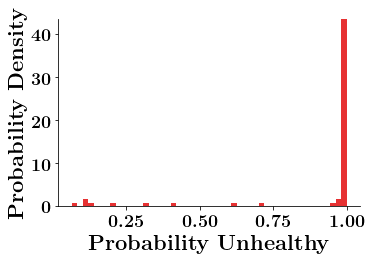

No handles with labels found to put in legend.


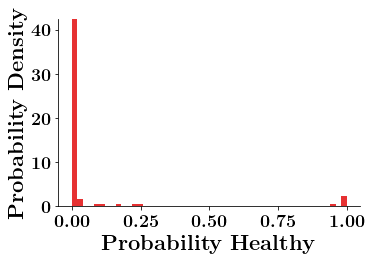

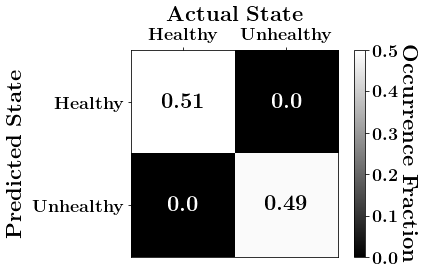

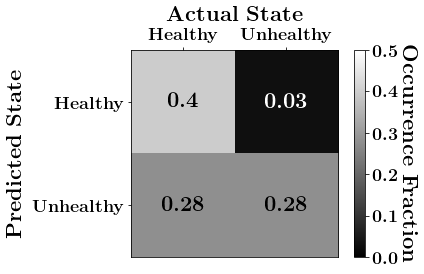

(1.0, 1.0, 1.0)
(0.74573055028463, 0.5882352941176471, 0.9032258064516129)


In [36]:
genplt.plot_histogram(model.predict(X_valid_unhealthy[...,np.newaxis])[:,1],[''],
               'Probability Unhealthy',
               'Probability Density',
               'mlp_predict_unhealthy',
               template='publication',
               legend_loc='upper right',
               nbins=50,
               ymax=0.0,
               num_col=1)

genplt.plot_histogram(model.predict(X_valid_healthy[...,np.newaxis])[:,0],[''],
               'Probability Healthy',
               'Probability Density',
               'mlp_predict_healthy',
               template='publication',
               legend_loc='upper right',
               ymax=0.0,
               nbins=50,
               num_col=1)

balanced_train_accuracy = plot_confusion_matrix(Y_train,Y_mlp_train_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_train'
                       )

balanced_valid_accuracy = plot_confusion_matrix(Y_valid,Y_mlp_valid_pred,
                      [r'\textbf{Healthy}',r'\textbf{Unhealthy}'],
                      'mlp_confmatrix_valid'
                       )
print(balanced_train_accuracy)
print(balanced_valid_accuracy)

In [37]:

conf_matrix_cnn_valid = confusion_matrix(Y_valid, Y_cnn_valid_pred)
accuracy_cnn_valid = np.sum(np.diagonal(conf_matrix_cnn_valid)) / np.sum(conf_matrix_cnn_valid)
print(conf_matrix_cnn_valid)
print(accuracy_cnn_valid)

conf_matrix_cnn_train = confusion_matrix(Y_train, Y_cnn_train_pred)
accuracy_cnn_train = np.sum(np.diagonal(conf_matrix_cnn_train)) / np.sum(conf_matrix_cnn_train)
print(conf_matrix_cnn_train)
print(accuracy_cnn_train)

[[ 7 58]
 [ 5 81]]
0.5827814569536424
[[  2 154]
 [  0 150]]
0.49673202614379086
